In [ ]:
# !unzip -q '/content/captures.zip' -d captures
# ! pip install barbar

In [ ]:
import glob
import numpy as np
import pandas as pd
import time

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

from torch.utils.data import Dataset, IterableDataset , DataLoader
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I
import torch.optim as optim

import torch
from torchvision import transforms, utils

from barbar import Bar

import cv2

os.makedirs('./saved_models', exist_ok=True)

path = "/content"

--------------**Uitility**-------------------

In [ ]:
class KeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir = 'captures', folder="Train/" , kp_file = 'image_%05d_img', transform=None, length=5):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = os.path.join(path, root_dir)
        self.key_pts_file = os.path.join(folder, kp_file)
        self.transform = transform
        
        files = os.listdir(os.path.join(self.root_dir, folder))
        self.dataLen = int(len(files)/length)
        
    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):
        
        orb_image = mpimg.imread(os.path.join(self.root_dir, "{}-ORB.png".format(self.key_pts_file %idx)))
        if(orb_image.shape[2] == 4):
                orb_image = orb_image[:,:,0:3]

        
        image = mpimg.imread(os.path.join(self.root_dir, "{}.png".format(self.key_pts_file %idx)))
        if(image.shape[2] == 4):
                image = image[:,:,0:3]

        KPs = pd.read_csv(os.path.join(self.root_dir, "{}-GT.txt".format(self.key_pts_file %idx)), header=None).to_numpy()

        sample = {'orb_image':orb_image, 'image': image, 'keypoints': KPs.astype('float')}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
# tranforms
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]
        
        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}


------------------**Visualize**------------------

In [ ]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10, savefig = False, plot=True):
  
    for i in range(0, batch_size):
        plt.figure(figsize=(20,10))
        #ax = plt.subplot(i+1, 1, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100

        #print("predicted_key_pts" , predicted_key_pts, ground_truth_pts)
        
        filename = 'Output-{}.png'.format(i) if savefig else None
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts,fileName = filename, plot=plot)
        
        #print('RMS error for image %d is : %03f' %(i, np.sqrt(mean_squared_error(ground_truth_pts, predicted_key_pts))))
            
        #plt.axis('off')

    plt.show()

def show_all_keypoints(image, predicted_key_pts, gt_pts=None, fileName = None ,plot=False):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    
    if plot:
        plt.plot(predicted_key_pts[:, 0], predicted_key_pts[:, 1], c='m', label='Predicted')
        # plot ground truth points as green pts
        if gt_pts is not None:
            plt.plot(gt_pts[:, 0], gt_pts[:, 1], c='g', label='True')
    else:
        plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
        # plot ground truth points as green pts
        if gt_pts is not None:
            plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')
    
    if fileName is not None:
        plt.savefig("OutputKP/{}".format(fileName))

---------------**MODEL**-----------------------

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        #obejctive is to bring down the image size to single unit-->
        #here given image size is 224x224px
        self.conv1 = nn.Conv2d(1, 32, 5)
        #224--> 224-5+1=220
        self.pool1 = nn.MaxPool2d(2, 2)
        #220/2=110 ...(32,110,110)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        #110--> 110-3+1=108
        self.pool2 = nn.MaxPool2d(2, 2)
        #108/2=54
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        #54-->54-3+1=52
        self.pool3 = nn.MaxPool2d(2, 2)
        #52/2=26
        
        self.conv4 = nn.Conv2d(128, 256, 3)
        #26-->26-3+1=24
        self.pool4 = nn.MaxPool2d(2, 2)
        #24/2=12
        
        self.conv5 = nn.Conv2d(256,512,1)
        #12-->12-1+1=12
        self.pool5 = nn.MaxPool2d(2,2)
        #12/2=6
        
        #6x6x512
        self.fc1 = nn.Linear(6*6*512 , 1024)
#         self.fc2 = nn.Linear(1024,1024)
        self.fc2 = nn.Linear(1024, 36)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)
        #self.fc2_drop = nn.Dropout(p=.5)
            
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop5(self.pool5(F.relu(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.drop6(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x

In [ ]:
def train_net(n_epochs, train_loader, net):
  
    device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')
    #criterion = nn.CrossEntropyLoss().to(device)
    criterion = nn.MSELoss().to(device)

    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params = net.parameters(), lr = 0.001)
    net.to(device)
    # prepare the net for training
    net.train()
    start = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = list()

        # train on batches of data, assumes you already have train_loader
        for data in Bar(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images.to(device))
            #output_pts = output_pts.type(torch.FloatTensor)
            #print(output_pts.type)
            #print(key_pts.type)
            # calculate the loss between predicted and target keypoints
            #print(key_pts.shape, output_pts.shape)
            loss = criterion(key_pts.to(device), output_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss.append(loss.item())
          
        print('Epoch: {}, Avg. Loss: {} : time : {}'.format(epoch + 1, torch.mean(torch.FloatTensor(running_loss)), (time.time()-start)))
                
    checkpoint = {'model': net.state_dict()}
    torch.save(checkpoint, './saved_models/model_checkpoint_kpd.pt')

    print('Finished Training')

In [ ]:
def test_net(test_loader, net):

    device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')
    net.to(device)
    # iterate through the test dataset
    errors = []
    for i, sample in enumerate(test_loader):
        net.eval()
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints'].type(torch.FloatTensor)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        with torch.no_grad():
          output_pts = net(images.to(device))
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 18, -1)
        #print('size : ',key_pts.size(), output_pts)
        errors.append(torch.nn.MSELoss()(key_pts, output_pts.detach().cpu()))
        # break after first image is tested
        if i == 0:
          return images, output_pts, key_pts, torch.mean(torch.FloatTensor(errors))


----------------**Train/Test**----------------

In [ ]:
# order matters! i.e. rescaling should come before a smaller crop
train_data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(255),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
train_transformed_dataset = KeypointsDataset(transform=train_data_transform, length=6)

batch_size = 10
train_loader = DataLoader(train_transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=10)


In [9]:
#train your network
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

net = Net()
train_net(n_epochs, train_loader, net)

100/100: [============================>...] - ETA 10.0s
Epoch: 1, Avg. Loss: 1.7894115447998047 : time : 10.594603776931763
100/100: [============================>...] - ETA 9.7s
Epoch: 2, Avg. Loss: 1.3620256185531616 : time : 21.089728593826294
100/100: [============================>...] - ETA 9.8s
Epoch: 3, Avg. Loss: 1.392575979232788 : time : 31.644587755203247
100/100: [============================>...] - ETA 9.2s
Epoch: 4, Avg. Loss: 1.3854024410247803 : time : 42.074772357940674
100/100: [============================>...] - ETA 9.9s
Epoch: 5, Avg. Loss: 1.3820374011993408 : time : 52.544028759002686
100/100: [============================>...] - ETA 9.7s
Epoch: 6, Avg. Loss: 1.402174711227417 : time : 62.96908473968506
100/100: [============================>...] - ETA 9.7s
Epoch: 7, Avg. Loss: 1.3089967966079712 : time : 73.38499021530151
100/100: [============================>...] - ETA 9.3s
Epoch: 8, Avg. Loss: 1.384186029434204 : time : 83.80710124969482
100/100: [===========

In [ ]:
test_data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(255),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_test_dataset = KeypointsDataset(folder="Test/",transform=test_data_transform, length=6)

batch_size =  10

test_loader = DataLoader(transformed_test_dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

In [14]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
# net = Net()
# net.load_state_dict(torch.load('./saved_models/model_checkpoint_kpd.pt')['model'])

test_images, test_outputs, gt_pts, error = test_net(test_loader, net)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())
print(error)

torch.Size([10, 1, 255, 255])
torch.Size([10, 18, 2])
torch.Size([10, 18, 2])
tensor(1.2627)


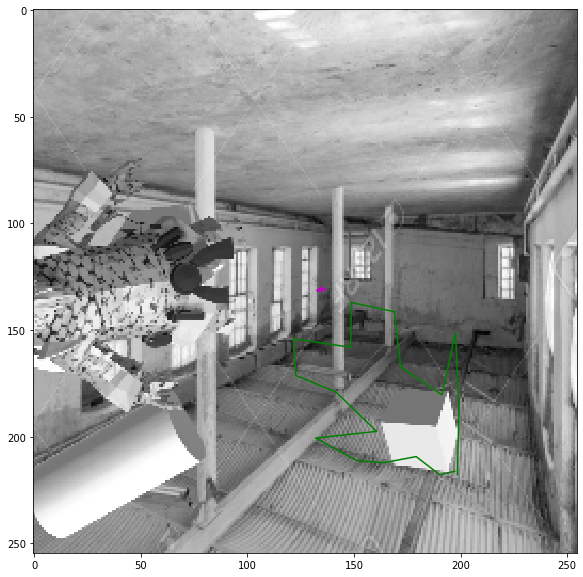

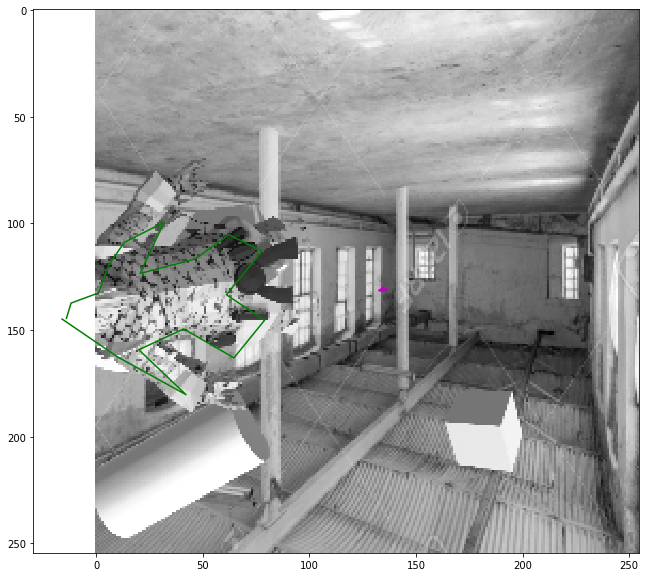

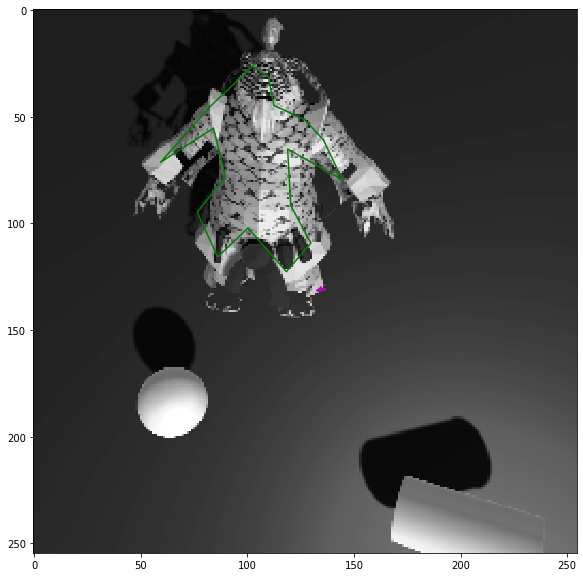

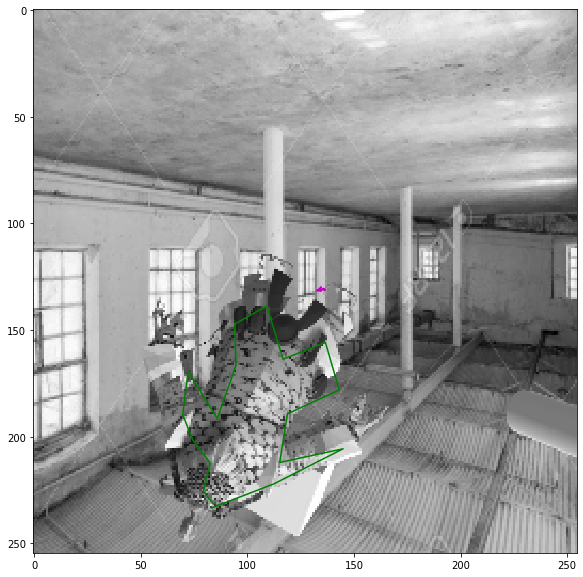

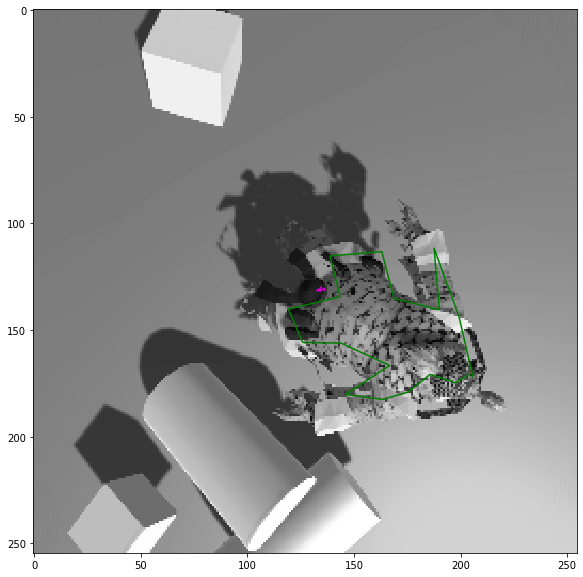

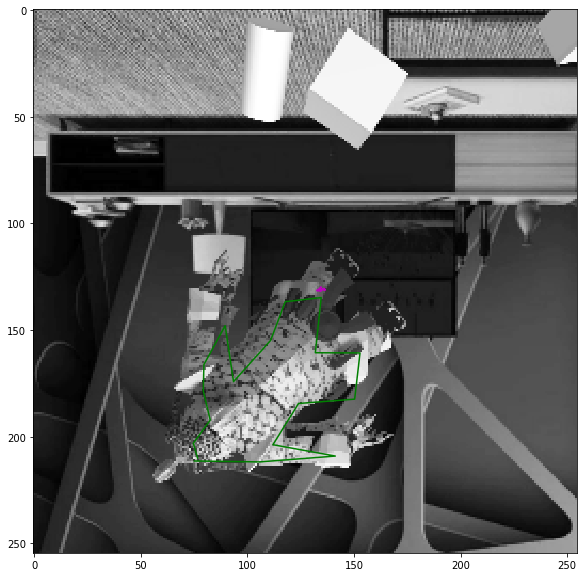

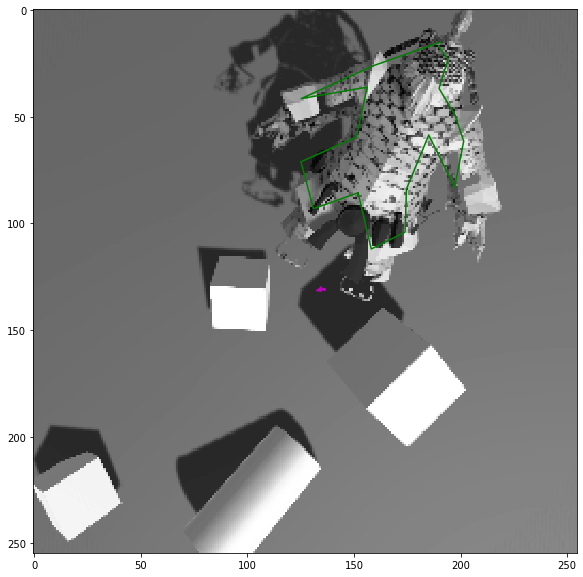

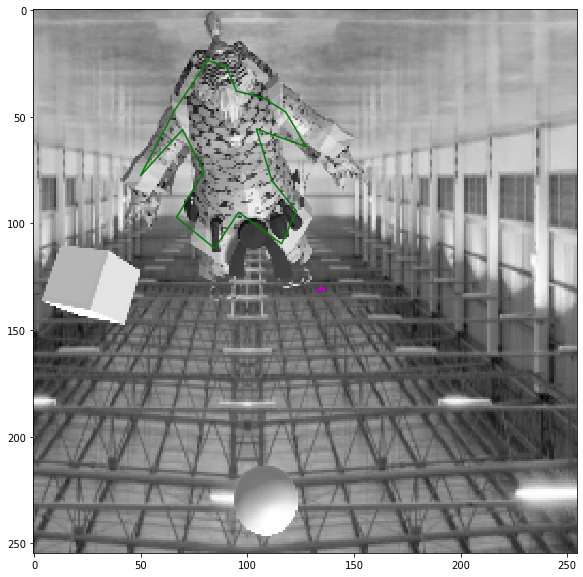

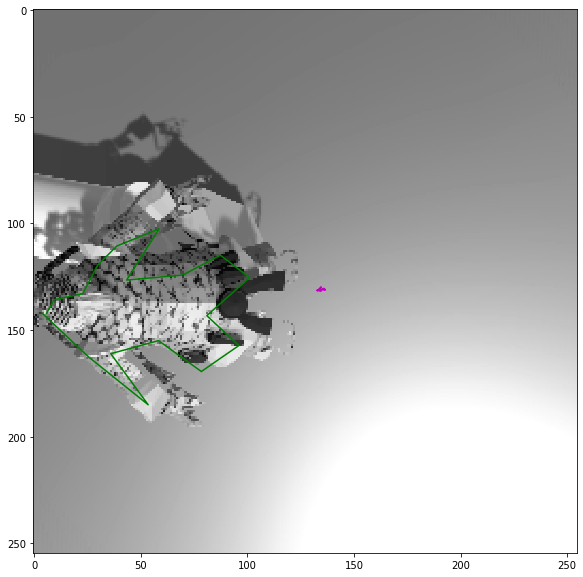

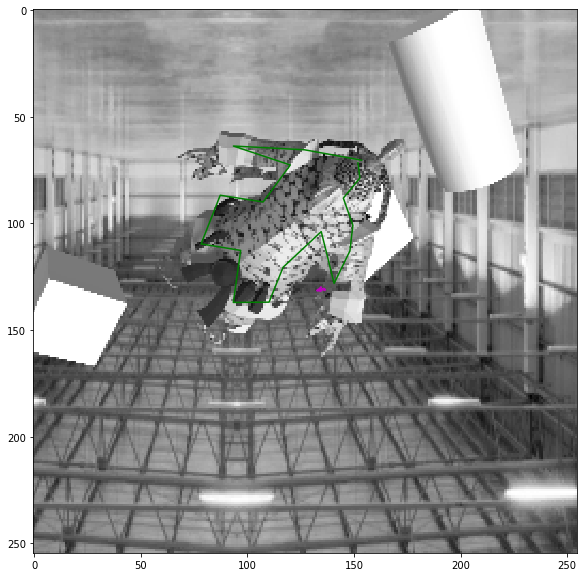

In [17]:
# print(gt_pts)
# print((test_outputs) )

visualize_output(test_images, test_outputs, gt_pts, batch_size=batch_size, savefig=True, plot=True)